<a href="https://colab.research.google.com/github/ngctnnnn/Math-for-Computer-Science-/blob/main/Softmax_Regression_with_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [213]:
#!pip install d2l

In [214]:
%matplotlib inline
from d2l import tensorflow as d2l 
import tensorflow as tf
import numpy as np 
import matplotlib.pyplot as plt 
from IPython import display 

In [215]:
#initialize 
batch_size = 256

x_train, x_test = d2l.load_data_fashion_mnist(batch_size)
#we load 256 input size from fashion mnist to get our dataset

In [216]:
input_number = 784
output_number = 10
#we construct our input dataset a 784 by 10 matrix 

w = tf.Variable(tf.random.normal(shape = (input_number, output_number), mean = 0, stddev = .01))
#our input variable w is generated by a Gaussian distribution with mean of 0
#and standard deviation of 0.01 

b = tf.Variable(tf.zeros(output_number))
#b is a 0 vector of size 10
w, b

(<tf.Variable 'Variable:0' shape=(784, 10) dtype=float32, numpy=
 array([[ 0.01108443, -0.00109644,  0.00492876, ...,  0.02464261,
          0.00619348, -0.00441165],
        [-0.00272216, -0.01001735,  0.00312728, ...,  0.00864082,
         -0.02107659, -0.01432932],
        [-0.00053271,  0.01055781, -0.00300646, ..., -0.00676571,
         -0.00636542,  0.00106596],
        ...,
        [ 0.0060861 , -0.00820968, -0.00302979, ..., -0.00997391,
          0.0049184 , -0.00806495],
        [ 0.00625946, -0.00064155, -0.00716862, ...,  0.00496358,
         -0.002711  , -0.00452569],
        [-0.02607229,  0.00854281,  0.01188796, ..., -0.00495773,
          0.00198337,  0.01617668]], dtype=float32)>,
 <tf.Variable 'Variable:0' shape=(10,) dtype=float32, numpy=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>)

We define the mathematical formula for Softmax function:
$$
\mathrm{Softmax(X_{i})} = \frac{e^{x_i}}{\sum_{i}e^{x_i}}
$$

In [217]:
def softmax(X):
    X_exp = tf.exp(X)
    partition = tf.reduce_sum(X_exp, 1, keepdims=True)
    return X_exp / partition
    #use above instead of below in order to avoid overflowing 
    #return tf.exp(x)/tf.reduce_sum(tf.exp(x), axis = 1, keepdims = True)

And then we define the loss function (or it can be called Cross Entropy function) for softmax:
$$
E_{in}(\omega) = \frac{1}{N}\sum_{i=1}^{N}log(\frac{1}{\theta(y_i\omega^{\top}x_i})
$$

In [218]:
def cross_entropy(y_hat, y):
    return -tf.math.log(tf.boolean_mask(y_hat, tf.one_hot(y, depth = y_hat.shape[-1])))
    #since cross entropy is used to calculate the loss of 2 distribution (2 bool variables)

And define our model as well:

In [219]:
def neural_network(x):
    return softmax(tf.matmul(tf.reshape(x, shape = (-1, w.shape[0])), w) + b)
    #calculate the value of input with softmax function softmax

Besides, we have to estimate the accuracy for each prediction.   


In [220]:
def accuracy(y_hat, y):
    if len(y_hat) > 1 and y_hat.shape[1] > 1:
        y_hat = tf.argmax(y_hat, axis = 1)
    #we assigned y_hat to the maximum value (argmax)
    
    cmp = tf.cast(y_hat, y.dtype) == y
    #tf.cast change the datatype of y_hat into y

    return float(tf.reduce_sum(tf.cast(cmp, y.dtype)))
    #change cmp datatype the same as y
    #sum up value of y
    #change the datatype of y into float

We need to define a function so as to sum over multiple variables. In this case, we use OOP:

In [221]:
class Accumulator:
    #initialize class 
    def __init__(self, n): 
        self.data = [0, 0] * n 
    #make the data value 0 matrix 

    def add(self, *args):
    #we use *args since we are unsure about number of arguments to use in this function
    #use *args when our variable have non keywords arguments
        self.data = [a + float(b) for a, b in zip(self.data, args)]
    
    def reset(self):
        self.data = [0, 0] * len(self.data)
    #give back the data value back to the initialize one

    def __getitem__(self, idx):
        return self.data[idx]
    #get the data with the index number idx 

Then we evaluate the accuracy throughout the model via x_test dataset:

In [222]:
def evaluate_accuracy(neural_network, x_test):
    metric = Accumulator(2)
    #sum over 2 variables

    for x, y in x_test:
        metric.add(accuracy(neural_network(x), y), tf.size(y).numpy())
        #add the accuracy between y_hat and y 
    return metric[0]/metric[1]

In order to minimize loss function, we use Stochastic Gradient Descent throughout the usage of class Update:

In [223]:
class update:
    def __init__(self, parameter, learning_rate):
        self.parameter = parameter 
        self.learning_rate = learning_rate
        #initialize update class 

    def __call__(self, batch_size, gradient):
        d2l.sgd(self.parameter, gradient, self.learning_rate, batch_size)
        #use stochastic gradient descent with a given learning_rate, batch_size and hyperparameter 

In [224]:
updater = update([w, b], learning_rate = 0.1)
updater

Model-training:

In [225]:
def train_epoch(neural_network, x_train, loss, updater):
    metric = Accumulator(3)
    
    for x, y in x_train:
        with tf.GradientTape() as tape:
            #apply gradient descent 
            y_hat = neural_network(x)
            #attach our model into y_hat 

            if isinstance(loss, tf.keras.losses.Loss):
            #return true if cross_entropy the same type as Loss function 
                l = loss(y, y_hat)
            else:
                l = loss(y_hat, y)
        
        if isinstance(updater, tf.keras.optimizers.Optimizer):
            parameter = neural_network.trainable_variables
            gradient = tape.gradient(l, parameter)
            #do gradient descent with parameter to minimize l
            updater.apply_gradients(zip(gradient, parameter))
            #apply gradient with our gradient function 

        else:
            updater(x.shape[0], tape.gradient(l, updater.parameter))
        
        if isinstance(loss, tf.keras.losses.Loss):
            l_sum = l * float(tf.size(y))
        else:
            l_sum = tf.reduce_sum(l)
            #sum up add the loss value 

        metric.add(l_sum, accuracy(y_hat, y), tf.size(y))

    # Return training loss and training accuracy
    return metric[0] / metric[2], metric[1] / metric[2]

In [226]:
class Animation:
    #animate training process 
    def __init__(self, xlabel = None, ylabel = None, legend = None, xlim = None, ylim = None, xscale = 'linear', yscale = 'linear', 
                 fmts = ('-', 'm--', 'g-.', 'r:'), nrows = 1, ncols = 1,
                 figsize = (3.5, 2.5)):
        
        #initialize points array 
        if legend is None:
            legend = []

        d2l.use_svg_display()
        #svg stands for scalable vector graphics 
        #visualize svg figures for a sharper figure 

        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize = figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]

        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        #lambda function is used the same as loop 
    
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
            
        n = len(y)
        
        if not hasattr(x, "__len__"):
            #hasattr can be understood as "has attribute"
            #used to check whether class x has the attribute of __len__
            x = [x] * n

        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]

        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)

        self.axes[0].cla()
        #cla or can be called clear axis 

        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)

        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait = True)

In [227]:
def training(neural_network, x_train, x_test, loss, num_epoch, update): 
    animator = Animation(xlabel = 'epoch', xlim = [1, num_epoch], ylim = [0.3, 0.9],
                        legend = ['Train_loss', 'Train_accuracy', 'Test_accuracy'])
    #animate training process 
    
    for epoch in range(num_epoch):
        #divide dataset into epochs and train individually
        train_metrics = train_epoch(neural_network, x_train, loss, update)
        #loop training process 

        test_accuracy = evaluate_accuracy(neural_network, x_test)
        #evaluate accuracy number to draw plot

        animator.add(epoch + 1, train_metrics + (test_accuracy, ))
        #draw plot throughout training 

    train_loss, train_accuracy = train_metrics

    assert train_loss < 0.5, train_loss
    assert train_accuracy <= 1 and train_accuracy > 0.7, train_accuracy
    assert test_accuracy <= 1 and test_accuracy > 0.7, test_accuracy
    #conditional sentences 
    #if the previous false, then assert the value of the following 

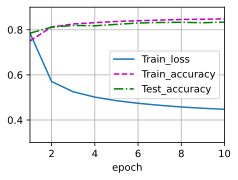

In [228]:
num_epochs = 10
training(neural_network, x_train, x_test, cross_entropy, num_epochs, updater)

In [229]:
def predict(neural_network, x_test, data_size):
    for x, y in x_test:
        break
    x_test = d2l.get_fashion_mnist_labels(y)
    prediction = d2l.get_fashion_mnist_labels(tf.argmax(neural_network(x), axis = 1))

    titles = ['corr: ' + true +'\n' + 'pred: ' + pred + '\n' for true, pred in zip(x_test, prediction)]
    d2l.show_images(tf.reshape(x[0 : data_size], (data_size, 28, 28)), 1, data_size, titles = titles[0 : data_size])

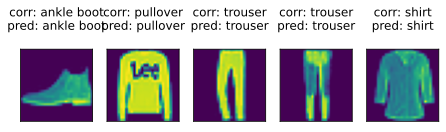

In [230]:
data_size = 5
predict(neural_network, x_test, data_size)
#check our model